[View in Colaboratory](https://colab.research.google.com/github/Charles-Xie/tensorflow_startup/blob/master/start/eager.ipynb)

**Copyright 2018 The TensorFlow Authors.**

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Get Started with Eager Execution

Note: you can run **[this notebook, live in Google Colab](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/get_started/eager.ipynb)** with zero setup.

This tutorial describes how to use machine learning to *categorize* Iris flowers by species. It uses [TensorFlow](https://www.tensorflow.org)'s eager execution to (1) build a *model*, (2) *train* the model on example data, and (3) use the model to make *predictions* on unknown data. Machine learning experience isn't required to follow this guide, but you'll need to read some Python code.

## TensorFlow programming

There many [TensorFlow APIs](https://www.tensorflow.org/api_docs/python/) available, but we recommend starting with these high-level TensorFlow concepts:

* Enable an [eager execution](https://www.tensorflow.org/programmers_guide/eager) development environment,
* Import data with the [Datasets API](https://www.tensorflow.org/programmers_guide/datasets),
* Build models and layers with TensorFlow's [Keras API](https://keras.io/getting-started/sequential-model-guide/).

This tutorial shows these APIs and is structured like many other TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

To learn more about using TensorFlow, see the [Getting Started guide](https://www.tensorflow.org/get_started/) and the [example tutorials](https://www.tensorflow.org/tutorials/). If you'd like to learn about the basics of machine learning, consider taking the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

## Run the notebook

This tutorial is available as an interactive [Colab notebook](https://colab.research.google.com) for you to run and change the Python code directly in the browser. The notebook handles setup and dependencies while you "play" cells to execute the code blocks. This is a fun way to explore the program and test ideas. If you are unfamiliar with Python notebook environments, there are a couple of things to keep in mind:

1. Executing code requires connecting to a runtime environment. In the Colab notebook menu, select *Runtime > Connect to runtime...*
2. Notebook cells are arranged sequentially to gradually build the program. Typically, later code cells depend on prior code cells, though you can always rerun a code block. To execute the entire notebook in order, select *Runtime > Run all*. To rerun a code cell, select the cell and click the *play icon* on the left.

## Setup program

### Install the latest version of TensorFlow

This tutorial uses eager execution, which is available in [TensorFlow 1.7](https://www.tensorflow.org/install/). (You may need to restart the runtime after upgrading.)

In [2]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.8.0)
Requirement not upgraded as not directly required: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.1.0)
Requirement not upgraded as not directly required: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.11.0)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.14.2)
Requirement not upgraded as not directly required: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (3.5.2.post1)
Requirement not upgraded as not directly required: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.2.0)
Requirement not upgraded as not directly required: wheel>=0.26 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.31.0)
Requirement not upgr

### Configure imports and eager execution

Import the required Python modules, including TensorFlow, and enable eager execution for this program. Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a [computational graph](https://www.tensorflow.org/programmers_guide/graphs) that is executed later. If you are used to a REPL or the `python` interactive console, you'll feel at home.

Once eager execution is enabled, it *cannot* be disabled within the same program. See the [eager execution guide](https://www.tensorflow.org/programmers_guide/eager) for more details.

In [3]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


## The Iris classification problem

Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. Machine learning provides many algorithms to statistically classify flowers. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify Iris flowers based on the length and width measurements of their [sepals](https://en.wikipedia.org/wiki/Sepal) and [petals](https://en.wikipedia.org/wiki/Petal).

The Iris genus entails about 300 species, but our program will classify only the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Fortunately, someone has already created a [data set of 120 Iris flowers](https://en.wikipedia.org/wiki/Iris_flower_data_set) with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

## Import and parse the training dataset

We need to download the dataset file and convert it to a structure that can be used by this Python program.

### Download the dataset

Download the training dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [4]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /content/.keras/datasets/iris_training.csv


In [5]:
!pwd
!ls ./ -al

/content
total 40
drwxr-xr-x 1 root root 4096 Apr 29 14:30 .
drwxr-xr-x 1 root root 4096 Apr 29 14:29 ..
drwx------ 4 root root 4096 Apr 29 14:30 .cache
drwxr-xr-x 3 root root 4096 Apr 29 14:30 .config
drwxr-xr-x 1 root root 4096 Apr 23 20:19 datalab
drwxr-xr-x 4 root root 4096 Apr 29 14:29 .forever
drwxr-xr-x 5 root root 4096 Apr 29 14:30 .ipython
drwxr-xr-x 3 root root 4096 Apr 29 14:30 .keras
drwx------ 3 root root 4096 Apr 29 14:30 .local
-rw------- 1 root root 1024 Apr 29 14:29 .rnd


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the `head -n5` command to take a peak at the first five entries:

In [6]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


From this view of the dataset, we see the following:

1. The first line is a header containing information about the dataset:
  * There are 120 total examples. Each example has four features and one of three possible label names. 
2. Subsequent rows are data records, one *[example](https://developers.google.com/machine-learning/glossary/#example)* per line, where:
  * The first four fields are *[features](https://developers.google.com/machine-learning/glossary/#feature)*: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
  * The last column is the *[label](https://developers.google.com/machine-learning/glossary/#label)*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

For more information about features and labels, see the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

### Parse the dataset

Since our dataset is a CSV-formatted text file, we'll parse the feature and label values into a format our Python model can use. Each line—or row—in the file is passed to the `parse_csv` function which grabs the first four feature fields and combines them into a single tensor. Then, the last field is parsed as the label. The function returns *both* the `features` and `label` tensors:

In [7]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

### Create the training tf.data.Dataset

TensorFlow's [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) handles many common cases for feeding data into a model. This is a high-level API for reading data and transforming it into a form used for training. See the [Datasets Quick Start guide](https://www.tensorflow.org/get_started/datasets_quickstart) for more information.

This program uses [tf.data.TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) to load a CSV-formatted text file and is parsed with our `parse_csv` function. A [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) represents an input pipeline as a collection of elements and a series of transformations that act on those elements. Transformation methods are chained together or called sequentially—just make sure to keep a reference to the returned `Dataset` object.

Training works best if the examples are in random order. Use `tf.data.Dataset.shuffle` to randomize entries, setting  `buffer_size` to a value larger than the number of examples (120 in this case). To train the model faster, the dataset's *[batch size](https://developers.google.com/machine-learning/glossary/#batch_size)* is set to `32` examples to train at once.

In [8]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([7.2 3.2 6.  1.8], shape=(4,), dtype=float32)
example label: tf.Tensor(2, shape=(), dtype=int32)


## Select the type of model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is the relationship between features and the label.  For the Iris classification problem, the model defines the relationship between the sepal and petal measurements and the predicted Iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the Iris species *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between petal and sepal measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

We need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the Iris classification problem. *[Neural networks](https://developers.google.com/machine-learning/glossary/#neural_network)* can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more *[hidden layers](https://developers.google.com/machine-learning/glossary/#hidden_layer)*. Each hidden layer consists of one or more *[neurons](https://developers.google.com/machine-learning/glossary/#neuron)*. There are several categories of neural networks and this program uses a dense, or *[fully-connected neural network](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*: the neurons in one layer receive input connections from *every* neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given Iris species. This prediction is called *[inference](https://developers.google.com/machine-learning/crash-course/glossary#inference)*. For this example, the sum of the output predictions are 1.0. In Figure 2, this prediction breaks down as: `0.03` for *Iris setosa*, `0.95` for *Iris versicolor*, and `0.02` for *Iris virginica*. This means that the model predicts—with 95% probability—that an unlabeled example flower is an *Iris versicolor*.

### Create a model using Keras

The TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together. See the [Keras documentation](https://keras.io/) for details.

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the amount of features from the dataset, and is required.

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

The *[activation function](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)* determines the output of a single neuron to the next layer. This is loosely based on how brain neurons are connected. There are many [available activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations), but [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

## Train the model

*[Training](https://developers.google.com/machine-learning/crash-course/glossary#training)* is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called *[overfitting](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)*—it's like memorizing the answers instead of understanding how to solve a problem.

The Iris classification problem is an example of *[supervised machine learning](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*: the model is trained from examples that contain labels. In *[unsupervised machine learning](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*, the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.losses.sparse_softmax_cross_entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) function which takes the model's prediction and the desired label. The returned loss value is progressively larger as the prediction gets worse.

In [10]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

The `grad` function uses the `loss` function and the [tfe.GradientTape](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/GradientTape) to record operations that compute the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model. For more examples of this, see the [eager execution guide](https://www.tensorflow.org/programmers_guide/eager).

### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorthims visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorthims visualized over time in 3D space. (Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License)<br/>&nbsp;
  </td></tr>
</table>

TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each epoch. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the amount of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

In [12]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

# for each epoch
for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  # for each batch in an epoch
  for x, y in tfe.Iterator(train_dataset):
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.461, Accuracy: 28.333%
Epoch 050: Loss: 0.339, Accuracy: 95.833%
Epoch 100: Loss: 0.202, Accuracy: 95.000%
Epoch 150: Loss: 0.137, Accuracy: 97.500%
Epoch 200: Loss: 0.107, Accuracy: 97.500%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

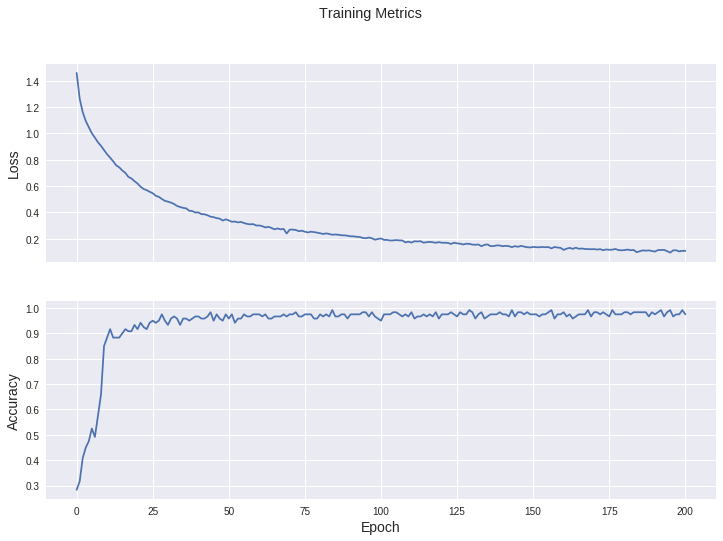

In [13]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

## Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's prediction against the actual label.  For example, a model that picked the correct species on half the input examples has an *[accuracy](https://developers.google.com/machine-learning/glossary/#accuracy)* of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> An Iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the CSV text file and parse that values, then give it a little shuffle:

In [14]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the function created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [15]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


## Use the trained model to make predictions

We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [16]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica


These predictions look good!

To dig deeper into machine learning models, take a look at the TensorFlow [Programmer's Guide](https://www.tensorflow.org/programmers_guide/) and check out the [community](https://www.tensorflow.org/community/).